In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [88]:
b_field_data = pd.read_csv('b_field_data.csv').drop(columns='Unnamed: 0')
test1 = pd.read_csv('test1.csv', header=None).iloc[:, [0, 2, 1]]
b_data = test1.merge(b_field_data, how='left', left_on=[2, 1], right_on=['lat', 'lon']).iloc[:, [0, 3, 4, 5, 6, 7]].rename(columns={0:'time'})
b_data.head()

,time,lat,lon,b_x,b_y,b_z
0,0,14.0,-137.2,228.8,38.0,146.4
1,10,14.0,-137.1,228.8,38.0,146.6
2,20,14.0,-137.1,228.8,38.0,146.6
3,30,14.0,-137.1,228.8,38.0,146.6
4,40,14.0,-137.1,228.8,38.0,146.6


In [142]:
def get_b(time):
    return np.array(b_data[b_data['time'] == time].iloc[0, [3, 4, 5]])

In [145]:
def rotation_matrix(a,b,c):
    return np.array([
        [np.cos(a)*np.cos(b)*np.cos(c)-np.sin(a)*np.sin(c), -np.cos(a)*np.cos(b)*np.sin(c)-np.sin(a)*np.cos(c), np.cos(a)*np.sin(b)],
        [np.sin(a)*np.cos(b)*np.cos(c)+np.cos(a)*np.sin(c), -np.sin(a)*np.cos(b)*np.sin(c)+np.sin(a)*np.cos(c), np.sin(a)*np.sin(b)],
        [-np.sin(b)*np.cos(c),np.sin(b)*np.sin(c), np.cos(b)]
    ])

In [146]:
def magnetorquer_out(mag_field_str, ang_vel, gain):
    scalar_coef = -gain / np.dot(mag_field_str, mag_field_str)
    magnetic_dipoles = scalar_coef * np.cross(mag_field_str, ang_vel)
    return np.cross(magnetic_dipoles, mag_field_str)

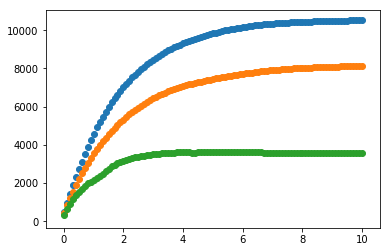

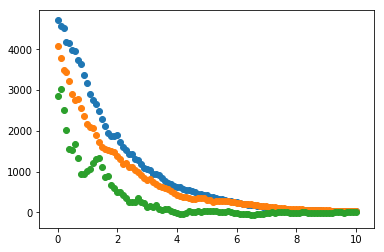

In [179]:
b = get_b(0)
ang_accel = []
ang_pos = []
inertia_matrix = np.array([ 
    [1308846.485, -10374.412, -13883.462],
    [-10374.412, 1334376.646, -21514.642],
    [-13883.462,-21514.642, 671472.124]
])/1000000 # kg * square meter
initial_ang_vel = np.array([5000,2000,5000])
def gain_func(t):
    return 1

def detumble(initial_b,initial_ang_vel, initial_ang_position, gain, time, dt):
    inverse_inertia_matrix = np.linalg.inv(inertia_matrix)
    ang_acceleration = np.matmul(inverse_inertia_matrix,(magnetorquer_out(initial_b, initial_ang_vel, gain)))
    
    ang_accel.append(ang_acceleration)
    new_ang_vel = initial_ang_vel + ang_acceleration*dt
    return new_ang_vel

def simulation(start,end,initial_b,initial_ang_vel,initial_ang_position,gain,dt):
    times = np.arange(start,end+dt,dt)
    vel_list = []
    vel_list_mag = []
    vel_list_x = []
    vel_list_y = []
    vel_list_z = []
    ang_list_x = []
    ang_list_y = []
    ang_list_z = []
    curr_vel = initial_ang_vel
    curr_ang = initial_ang_position
    curr_b = initial_b
    for t in times:
        curr_ang = curr_ang + curr_vel*dt
        curr_b = np.matmul(rotation_matrix(curr_ang[0],curr_ang[1],curr_ang[2]), initial_b)
        curr_vel = detumble(curr_b,curr_vel,curr_ang,gain(t),t,dt)
        vel_list.append(curr_vel)
        ang_pos.append(curr_ang)

    for i in vel_list:
        vel_list_x.append(i[0]) 
        vel_list_y.append(i[1])
        vel_list_z.append(i[2])
        
    for i in ang_pos:
        ang_list_x.append(i[0])
        ang_list_y.append(i[1])
        ang_list_z.append(i[2])
    
    for j in range(len(vel_list)):
        vel_list_mag.append(np.sqrt(vel_list_x[j]**2+vel_list_y[j]**2+vel_list_z[j]**2))
    plt.figure()
    plt.scatter(times,ang_list_x)
    plt.scatter(times,ang_list_y)
    plt.scatter(times,ang_list_z)
    plt.figure()
    plt.scatter(times,vel_list_x)
    plt.scatter(times,vel_list_y)
    plt.scatter(times,vel_list_z)
        
simulation(0,10,b,np.array([5000,4000,3000]), np.array([10,20,30]), gain_func,0.1)